# Example data processing to reproduce Figure 1

This notebook demonstrates how to run the BABY algorithm \[1\] to process bright-field images of budding yeast growing in a microfluidics device with ALCATRAS traps \[2\]. The notebook uses the image data from Figure 1 of \[1\] to reproduce the growth rate estimates shown in that figure. It also shows intermediate outputs of the algorithm, such as the segmentation outlines and tracking annotations. 

The necessary data for this notebook can be obtained from [https://doi.org/10.7488/ds/3427](https://doi.org/10.7488/ds/3427). Only the `Fig1_brightfield_and_seg_outputs.zip` file is required.

In order to run the notebook you will need to install the BABY Python package, which can be obtained from the repository at [https://git.ecdf.ed.ac.uk/swain-lab/baby](https://git.ecdf.ed.ac.uk/swain-lab/baby).

This notebook has a run-time of about 2 minutes (tested on MacBook Pro with 2GHz Intel i7 processor and Python 3.8).

**References**

1. Pietsch, Muñoz, Adjavon, Farquhar, Clark, Swain (2022) A label-free method to track individuals and lineages of budding cells.
2. Crane MM, et al. (2014) A microfluidic system for studying ageing and dynamic single-cell responses in budding yeast. PLoS One, 9(6):e100042.

## Load image data

Unzip `Fig1_brightfield_and_seg_outputs.zip` into the same folder as this notebook. This should produce a directory `Fig1_brightfield_and_seg_outputs` with sub-directories for each bright-field Z section (`brightfield_z1`, ...). Within each Z-section sub-directory should be image files labelled by time point (`time_point_001.png`, ...).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from imageio import imread

# Define top-level directory and names of Z section sub-directories
base_img_dir = Path(r'C:\Users\axfjr\Downloads\2025 Summer Research\swh_1_dir_9751e385e3e7a35035137c9defaecc60305ef551\swh_1_dir_9751e385e3e7a35035137c9defaecc60305ef551\python\notebooks\Fig1_brightfield_and_seg_outputs')
z_dir_names = [f'brightfield_z{i}' for i in range(1,6)]

# Load images for each Z section in a loop
bfimgs = []
for z in z_dir_names:
    # Get a list of all png files in the Z-section sub-directory
    zfiles = filter(lambda x: x.suffix == '.png', (base_img_dir / z).iterdir())
    # Sort by file name to guarantee ordering by time point
    zfiles = sorted(zfiles, key=lambda x: x.stem)
    # Load all files and stack them to form an N_timepoint * image_width * image_height array
    bfimgs.append(np.stack([imread(f) for f in zfiles]))

# Stack all Z-sections together to form an N_timepoint * image_width * image_height * N_zsections array
bfimgs = np.stack(bfimgs, axis=-1)

print('Shape of "bfimgs":', bfimgs.shape)

C:\Users\axfjr\AppData\Local\Temp\ipykernel_50432\3984649009.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bfimgs.append(np.stack([imread(f) for f in zfiles]))
c:\Users\axfjr\miniconda3\envs\baby\lib\site-packages\imageio\plugins\pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


Shape of "bfimgs": (300, 117, 117, 5)


### Inspect the input image time series

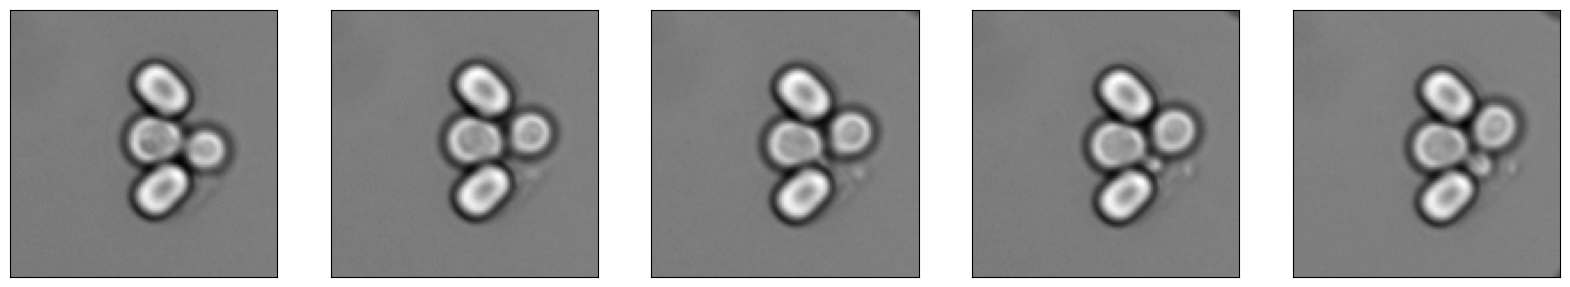

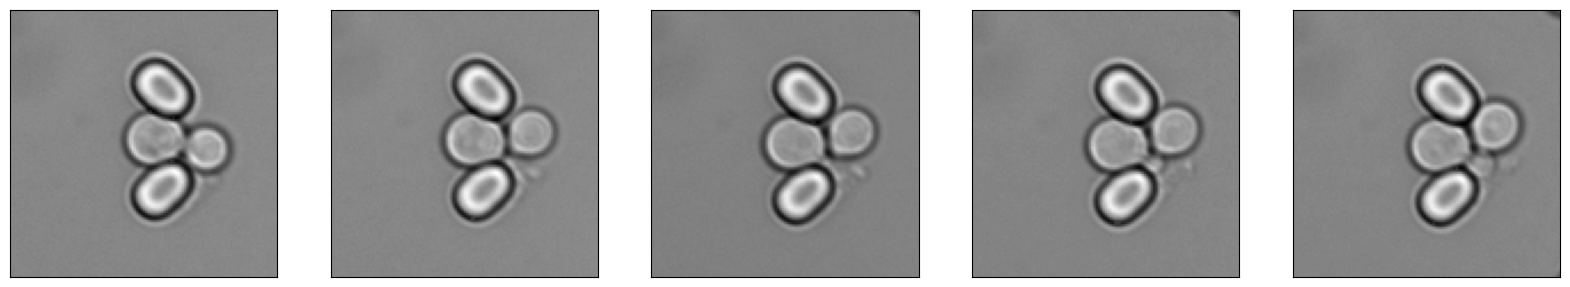

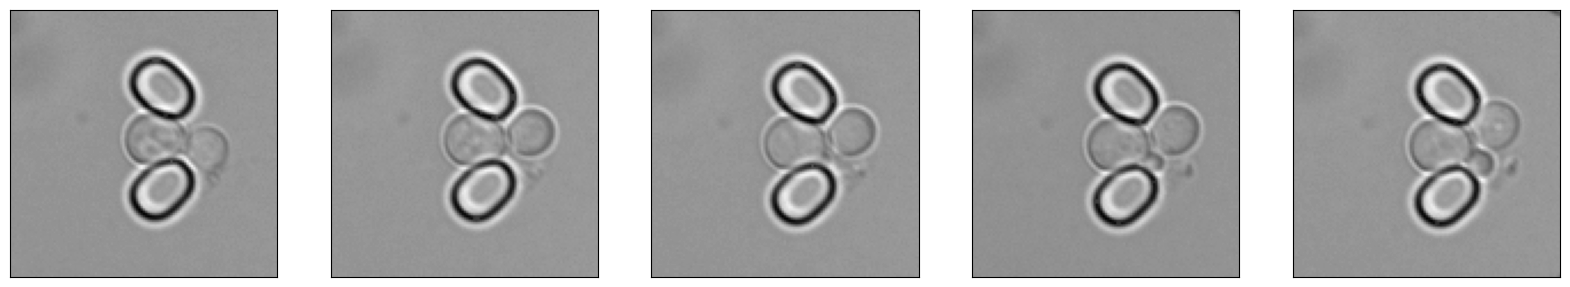

In [2]:
from baby.visualise import plot_ims

# Show every third time point from Z section 1
plot_ims(bfimgs[0:15:3, :, :, 0])

# Show every third time point from Z section 3
plot_ims(bfimgs[0:15:3, :, :, 2])

# Show every third time point from Z section 5
plot_ims(bfimgs[0:15:3, :, :, 4])

## Segment and track cells

A variety of different pre-trained models come packaged with BABY. These models are organised into sets according to the pixel size and number of input Z sections of the input images. The available sets can be retrieved via the `modelsets` function.

In [4]:
from baby import modelsets
display({k: v['pixel_size'] for k, v in modelsets.meta().items()})

{'ecoli-mothermachine-phase-EMCCD-100x-1z': 0.08,
 'yeast-traps-brightfield-orcafire-63x-1z': 0.068,
 'yeast-alcatras-brightfield-sCMOS-60x-5z': 0.182,
 'yeast-alcatras-brightfield-EMCCD-60x-1z': 0.263,
 'ecoli-mothermachine-phase-sCMOS-100x-1z': 0.065,
 'yeast-alcatras-brightfield-sCMOS-60x-1z': 0.182,
 'yeast-alcatras-brightfield-EMCCD-60x-5z': 0.263,
 'yeast-alcatras-brightfield-sCMOS-60x-3z': 0.182,
 'yeast-microcol-brightfield-sCMOS-100x-1z': 0.118,
 'yeast-alcatras-brightfield-EMCCD-60x-3z': 0.263}

The model sets are used to initialise a `BabyBrain` object, which coordinates the CNN and tracking models to process images at each time point. The images in this example have a pixel size of 0.182 µm and 5 Z sections, so we instantiate the `BabyBrain` with the `prime95b_brightfield_60x_5z` model set.

In [37]:
brain = modelsets.get('yeast-alcatras-brightfield-EMCCD-60x-5z')

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [32]:
from baby.brain import BabyBrain

import pickle
import sys
from enum import Enum
from pathlib import Path
from typing import Optional

import torch


brain = modelsets.get('yeast-alcatras-brightfield-EMCCD-60x-5z')

bb = BabyBrain(**modelsets.get('yeast-traps-brightfield-orcafire-63x-1z')['yeast-traps-brightfield-orcafire-63x-1z'])

h = modelsets.get('yeast-alcatras-brightfield-sCMOS-60x-3z')
bb = BabyBrain(**modelsets.get('yeast-alcatras-brightfield-sCMOS-60x-3z'))

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

We can use the `BabyBrain` to inspect the CNN outputs and segmented outlines for a single time point. The `segment` member function expects a batch of input images from a single time point, typically multiple distinct traps. Here, we provide it with multiple time points. Note that these will not be tracked.

In [30]:
seg_out = list(bb.segment(bfimgs[0:10, ...], yield_edgemasks=True, yield_preds=True, refine_outlines=True))

# Inspect just time point 8
tpi = 7 # indexing in python is from 0

# Display the CNN target outputs for time point 81
_, axs = plot_ims(seg_out[tpi]['preds'], show=False)
# Label each image with the target name
for ax, tgt in zip(axs, bb.flattener.targets):
    ax.set_title(tgt.name)
plt.show()

NameError: name 'bb' is not defined

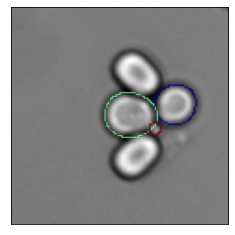

In [6]:
# Display the segmented outlines on a bright field section
from baby.visualise import colour_segstack
_, axs = plot_ims(bfimgs[tpi, :, :, 0][None, ...], show=False)
axs[0].imshow(colour_segstack(seg_out[tpi]['edgemasks']))
plt.show()

To simplify management of state when tracking cells across time points, it is easiest to use the `BabyCrawler` helper class to iterate over all time points.

In [7]:
from baby.crawler import BabyCrawler

# Instantiate a BabyCrawler from the BabyBrain instance loaded above
bc = BabyCrawler(bb)

# Step through all but the last time point
seg_time_course = []
for tp in bfimgs[:-1]:
    # The crawler expects a batch of images as the first index, so 
    # we add a new axis with tp[None, ...]
    seg_time_course += bc.step(tp[None, ...], with_edgemasks=True,
                               refine_outlines=True, with_volumes=True)

# For the last time point, we also include all lineage assignments in
# the output
seg_time_course += bc.step(bfimgs[-1][None, ...], with_edgemasks=True,
                           refine_outlines=True, with_volumes=True,
                           assign_mothers=True)

At each step, the crawler returns a `dict` that includes keys for the outlines (`edgemasks`), tracking labels (`cell_labels`) and estimated volumes (`volumes`). Here we display a subset of the bright-field images from Z-section 3 with outlines coloured by label:

dict keys at each step: ['centres', 'angles', 'radii', 'edgemasks', 'volumes', 'cell_label', 'ellipse_dims']


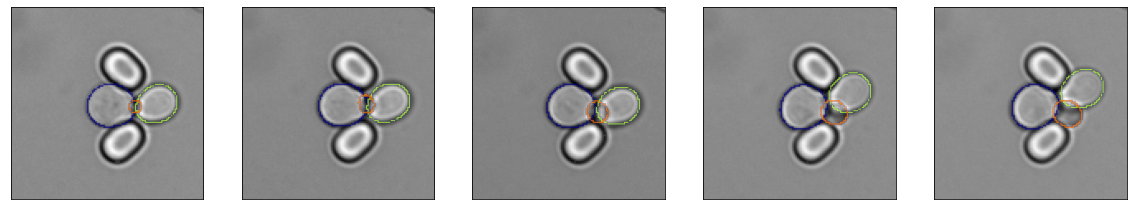

In [8]:
print('dict keys at each step:', list(seg_time_course[0].keys()))
_, axs = plot_ims(bfimgs[80:90:2, :, :, 2], show=False)
for ax, seg in zip(axs, seg_time_course[80:90:2]):
    ax.imshow(colour_segstack(seg['edgemasks'], labels=seg['cell_label'], max_label=15))
plt.show()

## Collate the volume data and estimate growth rates and birth times

At each step of the crawler, volume estimates are produced for each cell detected at that time point. The tracker also assigns a label/ID to each detected cell in the `cell_label` array. To obtain full traces for each tracked cell, we need to collect the volume estimates and organise them by cell label.

The last step of the crawler also includes an array `mother_assign` that specifies, for each cell, the label/ID of its mother. We can use this to filter to just the data for the trapped mother cell and all of its daughters.

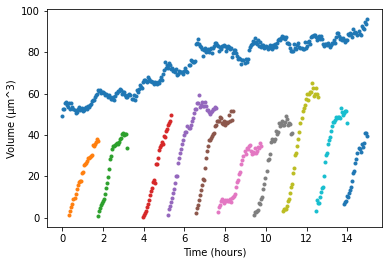

In [9]:
from itertools import chain

# First obtain the set of all cell labels encountered during the time course
cell_labels = set(chain(*(tp['cell_label'] for tp in seg_time_course)))
cell_labels = np.array(sorted(cell_labels))

# Then fill a N_cells * N_time_points matrix with the volume estimates
vols = np.full((len(cell_labels), len(seg_time_course)), np.nan)
for tp, seg in enumerate(seg_time_course):
    # Loop over each time point and fill volumes in according to cell label.
    # Note that cell labels start at 1, so we subtract 1 for Python indexing.
    vols[np.array(seg['cell_label']) - 1, tp] = seg['volumes']
    
# The volume estimates are in pixels^3, so we convert to µm^3 using the
# pixel size of the model
vols *= bb.pixel_size**3

# Get the mother assignments from the last time point. This is a list of
# cell labels specifying the mother cell identified for each cell label.
# Cell labels start at 1 and end at the number of unique cell
# tracks. In the mothers list, the value for a given cell is zero if
# the cell had no identified mother.
mothers = np.array(seg_time_course[-1]['mother_assign'])

# Find the trapped mother cell as the cell present for the most time points
cell_is_present = ~np.isnan(vols)
mother_ind = cell_is_present.sum(axis=1).argmax()
    
# Identify all of the daughters of this mother
daughter_inds = np.flatnonzero(mothers == cell_labels[mother_ind])

# Filter the data to the mother (first row) and all of its daughters
# (remaining rows):
vols = vols[np.hstack((mother_ind, daughter_inds)), :]
N_cells, N_tps = vols.shape

# Finally, plot the volume data

# Images in this data set are sampled at 3 minute intervals
times = np.arange(0, vols.shape[1]) * 3. / 60.  # hours

plt.plot(times, vols.T, '.')
plt.xlabel('Time (hours)')
plt.ylabel('Volume (µm^3)')
plt.show()

To determine growth rates from the volume estimates, we fit a Gaussian Process (GP) to each trace. The first derivative of the process w.r.t. time gives the instantaneous growth rate \[3\].

We can further estimate the time of cytokinesis ('birth' time) by finding the crossing points in daughter and mother growth ratess according to the algorithm described in \[1\].

**References**

3. Swain, P. S. et al. (2016) Inferring time derivatives including cell growth rates using Gaussian processes. Nat Commun 7, 13766.

In [10]:
from baby.postprocessing import growth_rates_from_volumes, cytokinesis_from_growth_rate

# Fit a Gaussian process (GP) to each of the volume traces
# and obtain derivatives wrt time:
gp_fit = growth_rates_from_volumes(times, vols)

# The first derivative of the GP is specified as both a
# mean and standard deviation
grs, grs_std = gp_fit.grs, gp_fit.grs_std

# For each daughter, we search for the time of birth (cytokinesis) at 
# time points between the first appearance of the bud...
start_tps = np.argmax(~np.isnan(vols), axis=1)
# ...and the appearance of the next bud:
end_tps = np.hstack([start_tps[1:], N_tps])
# NB: for the last daughter, we simply take the last available time point

btps = [
    cytokinesis_from_growth_rate(grs[d], grs_std[d], grs[0], grs_std[0],
                                 start_tps[d], end_tps[d])
    for d in range(1, N_cells)
]

Finally, we recreate the plot in Figure 1e:

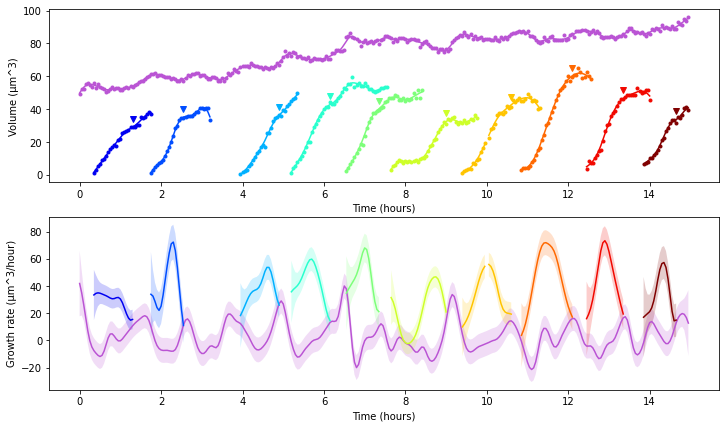

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12, 7))

# Loop over each track and plot with consistent colour
N_tracks = vols.shape[0]
for i in range(N_tracks):
    if i == 0:
        # This is the mother, so choose a distinct colour
        i_colour = [0.73, 0.33, 0.83]
    else:
        # Choose colours from the jet palette for the daughters
        i_colour = plt.cm.jet(i / (N_tracks - 1))
    
    # Plot the direct volume estimates as points
    axs[0].plot(times, vols[i], '.', color=i_colour)
    # Plot the Gaussian process volume estimates as lines
    axs[0].plot(times, gp_fit.vol[i], color=i_colour)
    if i > 0:
        # If this is a daughter, plot the birth time as an
        # inverted triangle
        btp = btps[i - 1]
        axs[0].plot(times[btp], gp_fit.vol[i][btp] + 5,
                    'v', color=i_colour)
    
    # Plot the estimated growth rate as lines with twice the standard
    # deviation of the first derivative of the Gaussian process
    i_times = times
    i_gr, i_gr_2std = grs[i], 2 * grs_std[i]
    if i > 0:
        # Show daughter growth rates only up until the birth time
        t_lim = btps[i - 1] + 1
        i_times = i_times[:t_lim]
        i_gr, i_gr_2std = i_gr[:t_lim], i_gr_2std[:t_lim]
    axs[1].plot(i_times, i_gr, color=i_colour)
    axs[1].fill_between(i_times, i_gr - i_gr_2std, i_gr + i_gr_2std,
                        facecolor=i_colour, alpha=0.2)

axs[0].set_xlabel('Time (hours)')
axs[0].set_ylabel('Volume (µm^3)')
axs[1].set_xlabel('Time (hours)')
axs[1].set_ylabel('Growth rate (µm^3/hour)')
plt.show()